In [28]:
%load_ext autoreload
%autoreload 2
import numpy as N
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import modules.plotmodule as pm
from modules.datahandler import getDataHandler
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from metpy.plots import ctables
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Some global parameters
rhoa = 1.0 # kg m^-3
cr = 1000.*N.pi/6.

sampling_area = dis.sensor_area
sampling_width = dis.sensor_width
sampling_length = dis.sensor_length

In [3]:
# Function definitions
def gammaDSD(D, cx,q ,Nt=None, N0=None, alpha=0):
    """Given cx, q, Nt or N0, and alpha, compute the gamma DSD for the sequence of diameters in D"""
    if(N0 is None):
        try:
            N0,_ = dsd.cal_N0(rhoa, q/1000., Nt, cx, alpha)
        except Exception:
            return None
    else:
        try:
            Nt = dsd.cal_Nt(rhoa, q/1000., N0, cx, alpha)
        except Exception:
            return None
        
    lamda = dsd.cal_lamda(rhoa, q/1000., Nt, cx, alpha)
    
    return N0*D**alpha*N.exp(-lamda*D), Nt, lamda, alpha

def samplegammaDSD(Nt, lamda, alpha, bins=None):
    """Randomly samples a gamma DSD given Nt, lamda, and alpha."""
    scale = 1./lamda
    shape = alpha+1.
    s = gamma.rvs(shape, scale=scale, size=int(Nt))
    # If desired, bin up the resulting samples into the given diameter ranges
    if(bins is None):
        return s
    else:
        ND_sample,_ = N.histogram(s, bins)
        return ND_sample/(bins[1:]-bins[:-1])

def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**8.5)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

def plotVD(Dl, Dmid, Vl, countsMatrix, Vt_fit, ax=None, strongwindflag=False):
    """Plot drop counts in each velocity/diameter bin for a given DSD"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    countsplot = ma.masked_where(countsMatrix <= 0, countsMatrix)

    C = ax.pcolor(Dl, Vl, countsplot, vmin=1, vmax=50, edgecolors='w')
    ax.plot(Dmid, Vt_fit, c='r')
    # ax1.scatter(X[0:10,20:31],Y[0:10,20:31],c='r',marker='x')
    fig.colorbar(C)

    if(strongwindflag):
        ax.text(0.5, 0.5, 'Flagged for strong wind contamination!',
                 horizontalalignment='center',
                 verticalalignment='center', color='y',
                 transform=ax.transAxes)
#     if(plot_strongwindQC):
#         ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
#     if(plot_splashingQC):
#         ax1.scatter(X[splashmask], Y[splashmask], c='w', marker='o', alpha=0.75)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_marginQC):
#         ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.1)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_rainfallspeedQC):
#         ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
#     if(plot_rainonlyQC):
#         ax1.scatter(X[rainonlymask], Y[rainonlymask], c='g', marker='x', alpha=0.5)

    ax.set_xlim(0.0, 9.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_xlabel('D (mm)')
    ax.set_ylim(0.0, 15.0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_ylabel(r'V$_T$ (m s$^{-1}$)')

def create_random_gamma_DSD(Nt, lamda, alpha, Vt, sampling_length, sampling_width, Dl, Dmid, Dr, Dmin=0, Dmax=8.0, 
                            sampling_interval=10., margins=False, verbose=False):
    """Given Nt, lamda, alpha, create a spatial distribution in a volume"""
    # First, determine the sampling volume. Use the sampling area A multiplied by the
    # depth that the fasted falling particle would cover in the time given by sampling_interval
    Dmax_index = N.searchsorted(Dr, Dmax/1000.)
    if verbose:
        print "Dmax_index = ",Dmax_index
    Vtmax = Vt[Dmax_index]
    sampling_height = Vtmax*sampling_interval
    sampling_area = sampling_length*sampling_width
    sampling_volume = sampling_area*sampling_height # Maximum sampling volume
    sampling_volumes_D = Vt[:Dmax_index+1]*sampling_interval*sampling_area # Sampling volumes as a function of diameter D 
    
    if verbose:
        print "sampling height = ",sampling_height
        print "sampling volume = ",sampling_volume
    
    # Next, create a uniform distribution of n=Nt*sampling_volume drops within the volume given by sampling_volume
    n = int(Nt*sampling_volume)
    if verbose:
        print "number concentration = ",Nt
        print "number of particles in sampling volume = ",n
    xpos = uniform.rvs(0., sampling_length, ((n, 1)))
    ypos = uniform.rvs(0., sampling_width, ((n, 1)))
    zpos = uniform.rvs(0., sampling_height, ((n, 1)))
    
    # Next, determine the sizes of the drops by drawing the diameters randomly from a gamma distribution
    # given by n, lamda, and alpha
    
    diameters = samplegammaDSD(n, lamda, alpha)
    
    # Restrict diameters to be less than Dmax
    diameter_mask = N.where(diameters <= Dmax/1000.)
    diameters = diameters[diameter_mask]
    xpos = xpos[diameter_mask]
    ypos = ypos[diameter_mask]
    zpos = zpos[diameter_mask]
    
    if verbose:
        print "number of particles less than Dmax = ",xpos.size
    
    # Now, figure out which drops in the volume won't fall through the sensor area in the given time, and remove them
    
    velocities = dis.assignfallspeed(diameters*1000.)
    depths = velocities*sampling_interval
    keepers = N.where(zpos.squeeze()-depths <= 0.)
    
    xpos = xpos[keepers]
    ypos = ypos[keepers]
    zpos = zpos[keepers]
    positions = N.hstack((xpos,ypos,zpos))
    diameters = diameters[keepers]
    velocities = velocities[keepers]
    
    if verbose:
        print "number of particles that fall through sampling area = ",xpos.size
    
    # Bin up particles into the Parsivel diameter bins (later will add velocity too; right now all particles
    # are assumed to fall strictly along theoretical/empirical fall speed curve)
    Dedges = N.append(Dl,Dr[-1])
    Dedges = Dedges[:Dmax_index+2]
    pcount_binned,_ = N.histogram(diameters, Dedges)
    # Compute ND of sample in original Parsivel diameter and velocity bins
    ND = pcount_binned/(sampling_volumes_D*(Dr[:Dmax_index+1]-Dl[:Dmax_index+1])) # Gets particle count/unit volume/diameter interval
    
    return positions, diameters, velocities, ND  

# From https://gist.github.com/syrte/592a062c562cd2a98a83
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

In [4]:
D = dis.avg_diameter/1000.
Dl = dis.min_diameter/1000.
Dr = dis.max_diameter/1000.

Dedges = N.append(Dl,Dr[-1])
print Dedges

qr = 1.0 # g kg^-1
N0r = 8.0e6 # M-P value (m^-4)

ND, Ntr, lamdar, alphar = gammaDSD(D, cr, qr, N0=N0r)
print Ntr

ND_sample = samplegammaDSD(Ntr, lamdar, alphar, bins=Dedges)

print ND
print ND_sample

[0.       0.000125 0.00025  0.000375 0.0005   0.000625 0.00075  0.000875
 0.001    0.001125 0.00125  0.0015   0.00175  0.002    0.00225  0.0025
 0.003    0.0035   0.004    0.0045   0.005    0.006    0.007    0.008
 0.009    0.01     0.012    0.014    0.016    0.018    0.02     0.023
 0.026   ]
3572.9753669520087
[6.95528742e+06 5.25733038e+06 3.97388650e+06 3.00376289e+06
 2.27047036e+06 1.71619260e+06 1.29722770e+06 9.80542454e+05
 7.41167880e+05 5.60230539e+05 3.68164629e+05 2.10349963e+05
 1.20182938e+05 6.86662284e+04 3.92322821e+04 1.69431493e+04
 5.53088834e+03 1.80549232e+03 5.89381365e+02 1.92396494e+02
 3.58837884e+01 3.82384074e+00 4.07475315e-01 4.34212992e-02
 4.62705138e-03 1.60955783e-04 1.82771975e-06 2.07545166e-08
 2.35676153e-10 2.67620056e-12 9.92024574e-15 1.20040268e-17]
[6904000. 5624000. 4008000. 2880000. 2064000. 1584000. 1256000.  968000.
  968000.  600000.  380000.  188000.  128000.   92000.   20000.   18000.
    8000.       0.       0.       0.       0.      

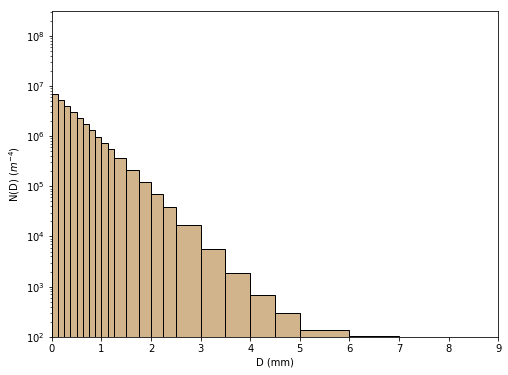

In [5]:
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)

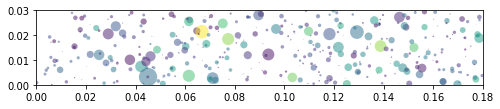

In [6]:
Vtr = dis.assignfallspeed(dis.avg_diameter)
positions, diameters, velocities, ND_sample = create_random_gamma_DSD(Ntr, lamdar, alphar, Vtr, sampling_length, sampling_width, Dl, D, Dr)

positions = positions.T
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
circles(positions[0], positions[1], diameters, c=positions[2], alpha=0.5)
#ax.scatter(positions[0], positions[1], c=positions[2], alpha=0.5, s=diameters*1000.)
ax.set_xlim(0.0, sampling_length)
ax.set_ylim(0.0, sampling_width)
ax.set_aspect('equal')

22


<BarContainer object of 23 artists>

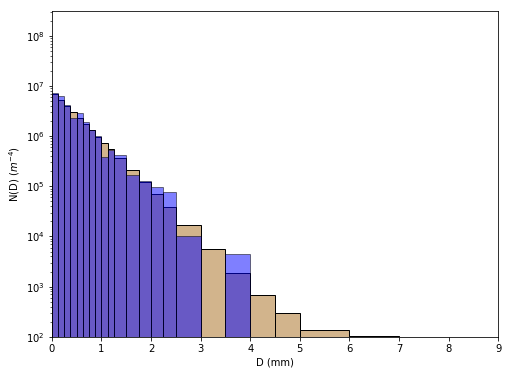

In [7]:
# Plot ND along with sampled ND
Dmax = 8.
Dmax_index = N.searchsorted(Dr, Dmax/1000.)
print Dmax_index
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)
ax.bar(Dl[:Dmax_index+1]*1000., ND_sample, (Dr-Dl)[:Dmax_index+1]*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5)


(0.0, 0.009)

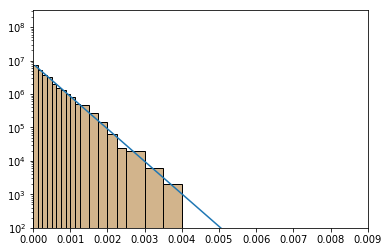

In [8]:
# Compute gamma distribution as a function of total number concentration and the PDF for the middle of each bin
shape = alphar+1
scale = 1./lamdar
x = D
s = Ntr*gamma.pdf(x, shape, scale=scale)

# Now sample the gamma distribution
s_sample = gamma.rvs(shape, scale=scale, size=int(Ntr))
# Bin up the samples into the Parsivel bins
s_binned,_ = N.histogram(s_sample, bins=Dedges)

# For plotting need to divide by the bin widths, since above we get number of drops/unit volume in each bin
# So this gives us number of drops/unit volume/diameter interval
s_sample_plot = s_binned/(Dr-Dl)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, s)
ax.bar(Dl, s_sample_plot, Dr - Dl, 10**2., align='edge', log=True, color='tan', edgecolor='k')
ax.set_yscale('log')
ax.set_ylim(10.**2.0, 10.**8.5)
ax.set_xlim(0.0,0.009)

# s_hist,_ = N.histogram(s, bins=50, density=True)
# print s_hist
# print s_hist.sum()
# count, bins, ignored = plt.hist(s, 50, normed=True)

In [63]:
# Let's try to read in a COMMAS model file and see if we can reproduce my Radar Conference 2015 poster plot first
modelname = 'COMMAS'
dirname = '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060509/1km/'
runname = 'jun05ZVDH3MCCN1imlt2_nz61'
times = [10800.]
multitime = True
microphys = 'ZVD'
jindex = 55
slc = (Ellipsis, slice(None), jindex, slice(None))
jend = 1

dh = getDataHandler(modelname, dirname, times, microphys, multitime=multitime)
dh.setRun(runname, 0)
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()

In [64]:
dh.loadTimes()
time = times[0]
timestring = dh.setTime(time)
dp_data, consts = dh.loadMicrophysics()
dp_data_2D = {}
for key, dat in dp_data.iteritems():
    dp_data_2D[key] = N.asfortranarray(dat[slc].copy())
dp_data_plot = {}
for key, dat in dp_data_2D.iteritems():
    dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()


Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


(100, 100, 60)
(101, 101) (101, 101)
[0.0, 100000.0] [0.0, 100000.0]
20000.0 20000.0


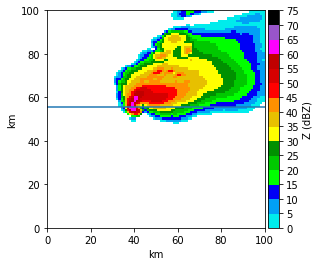

In [65]:
Zmod = dh.loadModelReflectivity()
print Zmod.shape
Zmodplot = Zmod[:, :, 0].T
xcplot = xc[0, :, :]
ycplot = yc[0, :, :]
xeplot = xe[0, :, :]
yeplot = ye[0, :, :]
xcorplot, ycorplot = pm.computecorners(xeplot, yeplot)

print xcorplot.shape, ycorplot.shape

fig = None
ax = None
ptype = 2
xlim = None
ylim = None
clevels = N.arange(0., 85., 5.)
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 0., 5.)
clabel = 'Z (dBZ)'
cformat = None
ovrmap = False
gis_info = None
numovr = 0
axesticks = [20000., 20000.]

fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                        clevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                        axesticks)

ax.axhline(ycplot[jindex, 0])

(101,)


/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


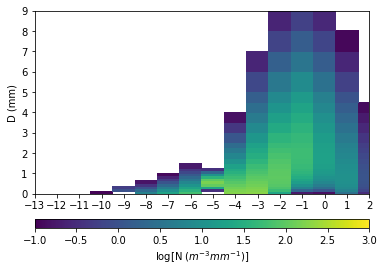

In [66]:
cr = N.pi/6.
xindexref = 40
xcplot = (xc[0,jindex,:]-xc[0,jindex,xindexref])/1000.
xeplot = (xe[0,jindex,:]-xc[0,jindex,xindexref])/1000.
N0r,_ = dsd.cal_N0(dp_data_2D['rhoa'],dp_data_2D['qr']/1000.,dp_data_2D['ntr'],
                                       cr,dp_data_2D['alphar'])
lamdar = dsd.cal_lamda(dp_data_2D['rhoa'],dp_data_2D['qr']/1000.,dp_data_2D['ntr'],
                                       cr,dp_data_2D['alphar'])
N0r = N0r[:,0]
lamdar = lamdar[:,0]
tmpalphar2 = dp_data_2D['alphar'][:,0]
Nc_bin = N.empty((N.size(N0r),N.size(D)))

print xeplot.shape


for index,dummy in N.ndenumerate(N0r):
    Nc_bin[index,:] = 1.e-3*N0r[index]*(D)**tmpalphar2[index]*N.exp(-lamdar[index]*(D))
Nc_bin = N.ma.masked_invalid(Nc_bin)
logNc_bin = N.log10(Nc_bin)
logNc_bin = N.ma.masked_where(logNc_bin <= -1.0,logNc_bin)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(xeplot,Dl*1000.,logNc_bin.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.set_xlim(-13.0,2.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')

plt.savefig('raw_modelDSD.png',dpi=300)

/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


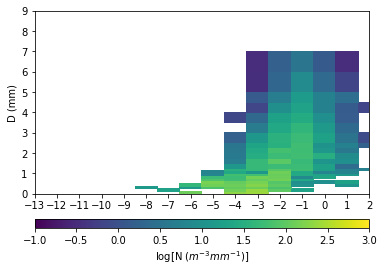

In [67]:
Nc_bin2 = N.empty((N.size(N0r),N.size(D[:Dmax_index+1])))
# Now plot the sampled distribution
for index,_ in N.ndenumerate(N0r):
    # print index,dp_data_2D['ntr'][index,0]
    positions, diameters, velocities, ND_sample = create_random_gamma_DSD(dp_data_2D['ntr'][index,0], lamdar[index], 
                                                                          tmpalphar2[index], Vtr, sampling_length, 
                                                                          sampling_width, Dl, D, Dr, sampling_interval=60)
    Nc_bin2[index,:] = 1.e-3*ND_sample

Nc_bin2 = N.ma.masked_invalid(Nc_bin2)
logNc_bin2 = N.log10(Nc_bin2)
logNc_bin2 = N.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(xeplot,Dl[:Dmax_index+1]*1000.,logNc_bin2.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.set_xlim(-13.0,2.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')
plt.savefig('sampled_modelDSD.png',dpi=300)

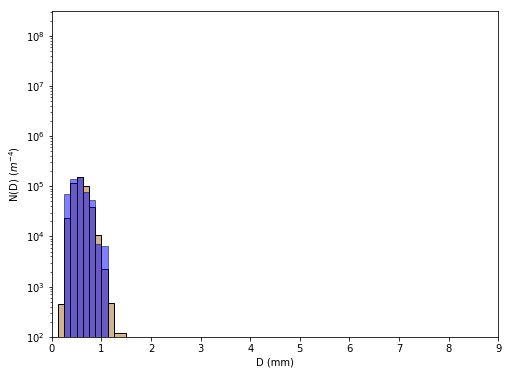

In [68]:
# Plot ND along with sampled ND

ax = plotDSD(Dl*1000., D*1000., Dr*1000., 1000.*Nc_bin[35,:])
ax.bar(Dl[:Dmax_index+1]*1000., 1000.*Nc_bin2[35,:], (Dr-Dl)[:Dmax_index+1]*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5)
plt.savefig('singleDSD_example.png',dpi=300)

In [69]:
# Ok, now do the same for one of the ARPS simulations of the 31 March 2016 case:
modelname = 'ARPS'
dirname = '/Volumes/depot/dawson29/data/for_Guo/from_Guo/033116/'
runname = '250mPUR04010000NSSL3MCCN2'
times = [3600.]
microphys = 'ZVD'
jindex = 192
slc = (Ellipsis, slice(None), jindex, slice(None))
jend = 1

dh = getDataHandler(modelname, dirname, times, microphys)
dh.setRun(runname, 0)
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()

Reading grid and map information from ARPS HDF file!


In [ ]:
dh.loadTimes()
time = times[0]
timestring = dh.setTime(time)
dp_data, consts = dh.loadMicrophysics()
dp_data_2D = {}
for key, dat in dp_data.iteritems():
    dp_data_2D[key] = N.asfortranarray(dat[slc].copy())

In [ ]:
cr = N.pi/6.
xindexref = 160
xcplot = (xc[0,jindex,:]-xc[0,jindex,xindexref])/1000.
xeplot = (xe[0,jindex,:]-xc[0,jindex,xindexref])/1000.
N0r,_ = dsd.cal_N0(dp_data_2D['rhoa'],dp_data_2D['qr']/1000.,dp_data_2D['ntr'],
                                       cr,dp_data_2D['alphar'])
lamdar = dsd.cal_lamda(dp_data_2D['rhoa'],dp_data_2D['qr']/1000.,dp_data_2D['ntr'],
                                       cr,dp_data_2D['alphar'])
N0r = N0r[:,0]
lamdar = lamdar[:,0]
tmpalphar2 = dp_data_2D['alphar'][:,0]
Nc_bin = N.empty((N.size(N0r),N.size(D)))

# print N0r
# print lamdar
# print tmpalphar2

print xeplot.shape


for index,dummy in N.ndenumerate(N0r):
    Nc_bin[index,:] = 1.e-3*N0r[index]*(D)**tmpalphar2[index]*N.exp(-lamdar[index]*(D))
Nc_bin = N.ma.masked_invalid(Nc_bin)
logNc_bin = N.log10(Nc_bin)
logNc_bin = N.ma.masked_where(logNc_bin <= -1.0,logNc_bin)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(xeplot,Dl*1000.,logNc_bin.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.set_xlim(-30.0,30.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')

plt.savefig('raw_modelDSD.png',dpi=300)

In [ ]:
Nc_bin2 = N.empty((N.size(N0r),N.size(D[:Dmax_index+1])))
# Now plot the sampled distribution
for index,_ in N.ndenumerate(N0r):
    # print index,dp_data_2D['ntr'][index,0]
    positions, diameters, velocities, ND_sample = create_random_gamma_DSD(dp_data_2D['ntr'][index,0], lamdar[index], 
                                                                          tmpalphar2[index], Vtr, sampling_length, 
                                                                          sampling_width, Dl, D, Dr, sampling_interval=60.)
    Nc_bin2[index,:] = 1.e-3*ND_sample

Nc_bin2 = N.ma.masked_invalid(Nc_bin2)
logNc_bin2 = N.log10(Nc_bin2)
logNc_bin2 = N.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(xeplot,Dl[:Dmax_index+1]*1000.,logNc_bin2.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.set_xlim(-30.0,30.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')
plt.savefig('sampled_modelDSD.png',dpi=300)